In [20]:
import time

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from torchvision import datasets, transforms
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.cuda as cuda
import torch

In [2]:
use_gpu = cuda.is_available()

# Learning to generate MNIST digits using a De-Convolutional Generator Discriminator model

In [3]:
class Generator(nn.Module):
    def __init__(self, n_channels=100, reuse=False ):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            #1st hidden layer
            nn.ConvTranspose2d(in_channels=n_channels, #"Deconvolutional" layer 
                               out_channels=1024,
                               kernel_size=4,
                               stride=1,
                               padding=0,
#                                bias=False
                              ),
            nn.BatchNorm2d(1024, affine=True),
            nn.LeakyReLU(negative_slope=0.2),
            
            #2nd hidden layer
            nn.ConvTranspose2d(in_channels=1024,
                               out_channels=512,
                               kernel_size=4,
                               stride=1,
                               padding=0,
#                                bias=False
                              ),
            nn.BatchNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=0.2),
            
            #3rd hidden layer
            nn.ConvTranspose2d(in_channels=512,
                               out_channels=256,
                               kernel_size=4,
                               stride=2,
                               padding=0,
#                                bias=False
                              ),
            nn.BatchNorm2d(256, affine=True),
            nn.LeakyReLU(negative_slope=0.2),
            
            #4th hidden layer
            nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                               kernel_size=4,
                               stride=2,
                               padding=1,
#                                bias=False
                              ),
            nn.BatchNorm2d(128, affine=True),
            nn.LeakyReLU(negative_slope=0.2),
            
            # output layer
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=1,
                               kernel_size=4,
                               stride=2,
                               padding=1,
#                                bias=False
                              ),
            nn.Tanh()
        )
    def forward(self, x):
        output = self.main(x)
        return output

In [4]:
class Discriminator(nn.Module):
    def __init__(self, reuse=False, n_channels=1):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            #1st hidden layer
            nn.Conv2d(in_channels=n_channels,
                      out_channels=128,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.LeakyReLU(negative_slope=0.2),
            
            #2nd hidden layer
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2),
            
            #3rd hidden layer
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=4,
                      stride=2,
                      padding=0,
                      bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2),
            
            #4th hidden layer
            nn.Conv2d(in_channels=512,
                      out_channels=1024,
                      kernel_size=4,
                      stride=2,
                      padding=0,
                      bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(negative_slope=0.2),
            
            #output layer
            nn.Conv2d(in_channels=1024,
                      out_channels=1,
                      kernel_size=4,
                      stride=1,
                      padding=1,
                      bias=False),
            nn.Sigmoid()
            
        )
    def forward(self, y):
        output = self.main(y)
        return output
        

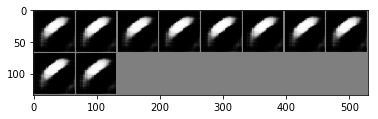

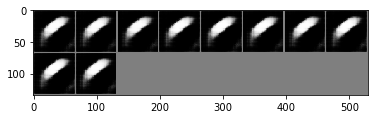

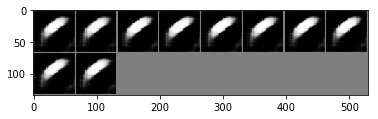

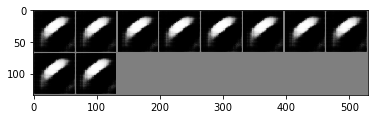

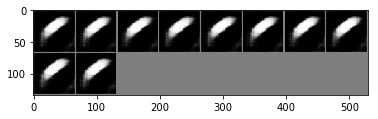

Variable containing:
(0 ,0 ,.,.) = 
  0.1878
[torch.cuda.FloatTensor of size 1x1x1x1 (GPU 0)]



In [19]:
# G = Generator().cuda()
# for i in range(5): imshow(torchvision.utils.make_grid(G(Variable(torch.rand([10, 100, 1, 1])).cuda()).data))
# D = Discriminator().cuda()
# print(D(G(Variable(torch.rand([1, 100, 1, 1])).cuda())))


In [6]:
# define transform
def get_data(img_size = 64, batch_size=128):
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform, )
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1 )
    # train_data_iter = iter(torch.Tensor(trainloader))
#     testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
#     testloader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=True, num_workers=1 )

    classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
    return trainloader, classes

torch.Size([128, 1, 64, 64])


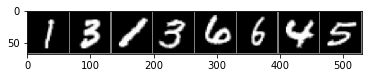

    1     3     1     3     6     6     4     5


In [7]:
def imshow(img, use_gpu=use_gpu):
    if use_gpu: img=img.cpu()
    img = img/2 + 0.5 # unnormalize
    npimg = img.numpy()
#     Permute the axes 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
trainloader, classes = get_data()
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.size())
images, labels = images[0:8], labels[0:8]

imshow(torchvision.utils.make_grid(images))
print(" ".join("%5s" % classes[labels[j]] for j in range(len(labels))))

In [8]:
def g_sampler(batch_size):
    return torch.rand([batch_size, 100, 1, 1])
# print(g_sampler().size())
# print(g_sampler().squeeze())

In [9]:
G = Generator()
D = Discriminator()
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(G.parameters())

In [57]:
def training(G, D, criterion, d_optimizer, g_optimizer, g_sampler, batch_size=128, num_epochs=20, epoch_int=10, d_steps=1, g_steps=1, use_gpu=use_gpu):
    print("Image processing starting")
    
    trainloader, _ = get_data(img_size = 64, batch_size=batch_size)
    dataiter = iter(trainloader)
    print("Image processing complete")
    if use_gpu:
        G = G.cuda()
        D = D.cuda()
        print("GPU in use!")
    else:
        print("CPU in use :(")
    
    print("Training Starting")
    start_time = time.time()    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
#         for d_real_images, _ in trainloader:
        if True:
            d_real_images, _ = dataiter.next()
            for d_i in range(d_steps):
                D.zero_grad()
                
                #on real
                d_real_images = Variable(d_real_images)
                if use_gpu: d_real_images = d_real_images.cuda()
                d_real_decision = D(d_real_images)
                d_real_ones = Variable(torch.ones([batch_size]))
                if use_gpu: d_real_ones = d_real_ones.cuda()
                d_real_error = criterion(d_real_decision.squeeze(), d_real_ones)
                d_real_error.backward()

                # on fake
                d_gen_input = Variable(g_sampler(batch_size=batch_size))
                if use_gpu: d_gen_input = d_gen_input.cuda() 
                d_fake_images = G(d_gen_input).detach()
                d_fake_decision = D(d_fake_images)
                d_fake_zeros = Variable(torch.zeros([batch_size]))
                if use_gpu: d_fake_zeros = d_fake_zeros.cuda()
                d_fake_error = criterion(d_fake_decision.squeeze(), d_fake_zeros)
                d_fake_error.backward()

                d_optimizer.step()
            for g_i in range(g_steps):
                G.zero_grad()

                gen_input = Variable(g_sampler(batch_size=batch_size))
                if use_gpu: gen_input = gen_input.cuda()
                g_fake_images = G(gen_input)
                fake_decision = D(g_fake_images)
                fake_decision_ones = Variable(torch.ones([batch_size]))
                if use_gpu: fake_decision_ones = fake_decision_ones.cuda()
                g_error = criterion(fake_decision.squeeze(), fake_decision_ones)
                g_error.backward()
                g_optimizer.step()
        epoch_end_time = time.time()   
        epoch_time = epoch_end_time - epoch_start_time
        epoch_time = time.strftime("%M mins %S secs", time.gmtime(epoch_time))
        print("%2s/%2s - epochTime: %10s | "%(epoch+1, num_epochs, epoch_time))
        if epoch % epoch_int == 0:
#             print("%3s / %3s epochs"% (epoch, num_epochs))
            imshow(torchvision.utils.make_grid(g_fake_images.data[0:3]))
    end_time = time.time()
    train_time = end_time-start_time
    train_time = time.strftime("%H hrs %M mins %S secs", time.gmtime(train_time))
    print("Training Time: %s"%(train_time))
    print("Training Complete!")

 1/ 1 - epochTime: 46 mins 40 secs | 


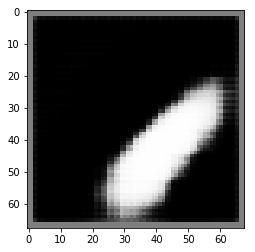

Training Time: 00 hrs 00 mins 02 secs
Training Complete!


In [58]:
training(G=G,
         D=D,
         criterion=criterion,
         d_optimizer=d_optimizer,
         g_optimizer=g_optimizer,
         g_sampler=g_sampler,
         batch_size=1,
         num_epochs=1,
         epoch_int=1,
        )

In [ ]:
torch.LongTensor(np.ones([50])).size()

In [24]:
k = criterion(Variable(torch.tensor(1)), Variable(torch.tensor(1)))

TypeError: 'module' object is not callable

### TODO:
- **DONE** Make GPU ready
- **DONE** Fix training to use all data.
- Add Noise.
- Collect Data during training.
- Use data collected to make graphs
- Output graphs to directory
- Save training values